In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
data = np.load('/u/scr/ethanchi/embeddings/temporal2/representations.npy')
print(data.shape)

(20000, 30, 768)


In [27]:
labels = pd.read_csv('/u/scr/ethanchi/embeddings/temporal2/sentences-cut.txt', sep="\t")
print(labels.columns)
print(labels.shape)

Index(['sentence', 'noun1', 'noun1_idx', 'verb1', 'verb1_idx', 'connector1',
       'connector1_idx', 'connector1_char', 'noun2', 'noun2_idx', 'verb2',
       'verb2_idx', 'connector2', 'connector2_idx', 'connector2_char', 'noun3',
       'noun3_idx', 'verb3', 'verb3_idx'],
      dtype='object')
(20000, 19)


In [ ]:
## FILTERS
to_use = lambda x: x in ('before', 'after')
filter_indices = [to_use(labels['connector1'])]
data = data[filter_indices]

In [28]:
# we train a direction vector
verb1_indices = labels['verb1_idx'].astype('int32').values
print(verb1_indices)
verb2_indices = labels['verb2_idx'].astype('int32').values
verb3_indices = labels['verb3_idx'].astype('int32').values

verb1_verb2_directions = np.where(labels['connector1_char'] == 'past', 1, -1)
verb2_verb3_directions = np.where(labels['connector2_char'] == 'past', 1, -1)

print(verb1_verb2_directions, verb2_verb3_directions)

[2 2 2 ... 2 2 2]
[-1  1 -1 ... -1  1  1] [ 1 -1  1 ...  1 -1 -1]


In [29]:
verb1_embeddings = data[np.arange(data.shape[0]), list(verb1_indices), :]
verb2_embeddings = data[np.arange(data.shape[0]), list(verb2_indices), :]

print(verb1_embeddings.shape, verb2_embeddings.shape)

(20000, 768) (20000, 768)


In [114]:
data_raw = (verb1_embeddings - verb2_embeddings) * verb1_verb2_directions[:, np.newaxis]
indices = np.arange(data_raw.shape[0])
np.random.shuffle(indices)
data_raw = data_raw[indices]


sep = int(indices.shape[0] * .9)

train_set_raw = data_raw[:sep]
test_set_raw = data_raw[sep:]

train_labels = labels.iloc[indices][:sep]
test_labels = labels.iloc[indices][sep:]

# train_set_raw = 
# test_set_raw = 

train_set = train_set_raw / np.linalg.norm(train_set_raw, axis=1, keepdims=True)
test_set = test_set_raw / np.linalg.norm(test_set_raw, axis=1, keepdims=True)

In [115]:
input_size = data.shape[-1]

class DirectionProbe(nn.Module):
    def __init__(self, inputSize):
        super(DirectionProbe, self).__init__()
        self.inputSize = inputSize
        self.u = nn.Parameter(data = torch.zeros(self.inputSize))
        nn.init.uniform_(self.u, -0.05, 0.05)
    def forward(self, batch):
        return torch.mean(batch @ (self.u / torch.norm(self.u)))

train_inputs = torch.Tensor(train_set)
test_inputs = torch.Tensor(test_set)
model = DirectionProbe(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_EPOCHS = 2000

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    output = model(train_inputs)
    error = 1 - output
    error.backward()
    optimizer.step()
    if epoch % 100 == 0:
        test_output = model(test_inputs)
        print("Epoch {}, train score {}, test score {}".format(epoch, output, test_output))


Epoch 0, train score 0.0012951323296874762, test score 0.0007616183720529079
Epoch 100, train score 0.0157218836247921, test score 0.017061658203601837
Epoch 200, train score 0.028660213574767113, test score 0.031564243137836456
Epoch 300, train score 0.039127930998802185, test score 0.043328847736120224
Epoch 400, train score 0.04634249955415726, test score 0.05156132951378822
Epoch 500, train score 0.05056342855095863, test score 0.056441809982061386
Epoch 600, train score 0.05270256847143173, test score 0.058940183371305466
Epoch 700, train score 0.05367755889892578, test score 0.06010020524263382
Epoch 800, train score 0.05409440025687218, test score 0.06061728298664093
Epoch 900, train score 0.054266612976789474, test score 0.06084717437624931
Epoch 1000, train score 0.05433699116110802, test score 0.06095145642757416
Epoch 1100, train score 0.05436604097485542, test score 0.06100013852119446
Epoch 1200, train score 0.054378263652324677, test score 0.06102341413497925
Epoch 1300, 

In [116]:
EPSILON = 0.0001
direction_vector = model.u.cpu().detach().numpy()
direction_vector /= np.linalg.norm(direction_vector)
numSuccessful = len(np.where(np.linalg.norm(train_set_raw + EPSILON * direction_vector, axis=1) > np.linalg.norm(train_set_raw, axis=1))[0])
print(numSuccessful / train_set_raw.shape[0])

0.5931666666666666


(2000, 19)
sentence           The cat walked earlier than the cat walked aft...
noun1                                                            cat
noun1_idx                                                          1
verb1                                                         walked
verb1_idx                                                          2
connector1                                              earlier than
connector1_idx                                                     3
connector1_char                                                 past
noun2                                                            cat
noun2_idx                                                          6
verb2                                                         walked
verb2_idx                                                          7
connector2                                                     after
connector2_idx                                                     8
connector2_char        

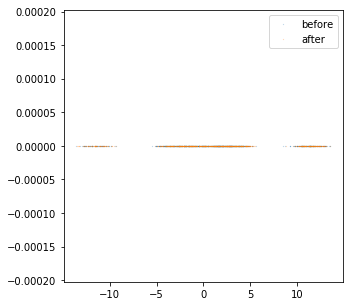

In [117]:
plt.figure(figsize=(5, 5))

test_directions = verb1_verb2_directions[sep:]

before = test_set_raw[test_directions == -1] @ direction_vector
after = test_set_raw[test_directions == 1] @ direction_vector

plt.scatter(before, np.zeros(before.shape[0]), label="before", s=0.01)
plt.scatter(after, np.zeros(after.shape[0]), label="after", s=0.01)

print(test_labels.shape)
print(test_labels[test_directions == -1].iloc[np.argmin(before)])
print(test_labels[test_directions == -1].iloc[np.argmax(before)])

plt.legend()

plt.show()

after 0.01845018450184502
before 0.9846153846153847
later than 0.7586206896551724
earlier than 0.2702702702702703
until 0.9914893617021276
then 0.9923664122137404
subsequently to 0.7710843373493976
(2000, 19)


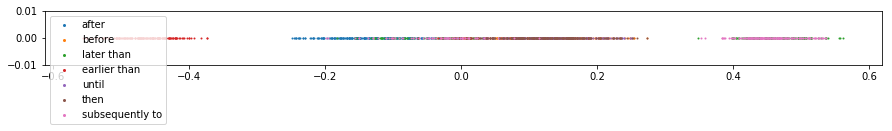

In [118]:
plt.figure(figsize=(15, 1))

test_directions = verb1_verb2_directions[sep:]


for word in ('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to'):
  arr = test_set[test_labels['connector1'] == word] @ direction_vector
  plt.scatter(arr, np.zeros(arr.shape[0]), label=word, s=1)
  print(word, len(np.where(np.linalg.norm(test_set[test_labels['connector1'] == word] + EPSILON * direction_vector, axis=1) > np.linalg.norm(test_set[test_labels['connector1'] == word], axis=1))[0]) /
       len(test_set[test_labels['connector1'] == word]))


print(test_labels.shape)

plt.legend(markerscale=2)

plt.show()

after 0.01845018450184502
before 0.9846153846153847
later than 0.7586206896551724
earlier than 0.2702702702702703
(2000, 19)


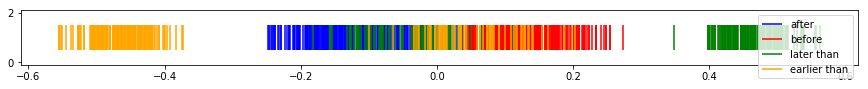

In [134]:
to_plot_data = (verb1_embeddings - verb2_embeddings)[indices][sep:]

assert(np.array_equal(((verb1_embeddings - verb2_embeddings) * verb1_verb2_directions[:, np.newaxis])[indices][sep:], test_set_raw))


plt.figure(figsize=(15, 1))

test_directions = verb1_verb2_directions[sep:]


# colors=['blue', 'red', 'green', 'orange', 'yellow', 'orangered', 'purple']

# for idx, word in enumerate(('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to')):
colors=['blue', 'red', 'green', 'orange']

for idx, word in enumerate(('after', 'before', 'later than', 'earlier than')):
  arr = test_set[test_labels['connector1'] == word] @ direction_vector
  plt.eventplot(arr, orientation='horizontal', label=word, colors=colors[idx], alpha=1)
  print(word, len(np.where(np.linalg.norm(test_set[test_labels['connector1'] == word] + EPSILON * direction_vector, axis=1) > np.linalg.norm(test_set[test_labels['connector1'] == word], axis=1))[0]) /
       len(test_set[test_labels['connector1'] == word]))


print(test_labels.shape)

plt.legend(markerscale=2)

plt.show()

after 0.01845018450184502
before 0.9846153846153847
later than 0.7586206896551724
earlier than 0.2702702702702703
until 0.9914893617021276
then 0.9923664122137404
subsequently to 0.7710843373493976
(2000, 19)


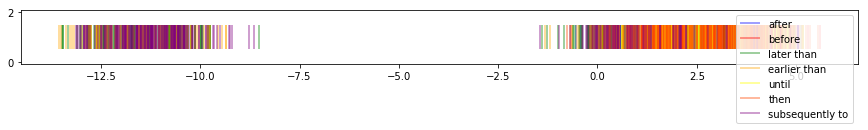

In [126]:
to_plot_data = (verb1_embeddings - verb2_embeddings)[indices][sep:]

plt.figure(figsize=(15, 1))

test_directions = verb1_verb2_directions[sep:]


# colors=['blue', 'red', 'green', 'orange', 'yellow', 'orangered', 'purple']

# for idx, word in enumerate(('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to')):
# colors=['blue', 'red', 'green', 'orange']

# for idx, word in enumerate(('after', 'before', 'later than', 'earlier than')):
colors=['blue', 'red', 'green', 'orange', 'yellow', 'orangered', 'purple']

for idx, word in enumerate(('after', 'before', 'later than', 'earlier than', 'until', 'then', 'subsequently to')):
  arr = to_plot_data[test_labels['connector1'] == word] @ direction_vector
  plt.eventplot(arr, orientation='horizontal', label=word, colors=colors[idx], alpha=0.5)
  print(word, len(np.where(np.linalg.norm(test_set[test_labels['connector1'] == word] + EPSILON * direction_vector, axis=1) > np.linalg.norm(test_set[test_labels['connector1'] == word], axis=1))[0]) /
       len(test_set[test_labels['connector1'] == word]))


print(test_labels.shape)

plt.legend(markerscale=2)

plt.show()